# Model Uncertainty and Calibration in Deep Learning

<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" align="left" src="https://i.creativecommons.org/l/by-nc-sa/4.0/80x15.png" /></a>&nbsp;| Dennis Wilson, Jérémy Pirard | <a href="https://supaerodatascience.github.io/deep-learning/">https://supaerodatascience.github.io/deep-learning/</a>

## Introduction

Modern deep learning models can achieve impressive accuracy, but **knowing when to trust a model's predictions** is equally important. Consider these scenarios:

- A medical diagnosis system predicts cancer with 95% confidence, but should we trust it?
- An autonomous vehicle classifies an object with high confidence—is it actually certain?
- A model says "90% confident" for 100 predictions—will exactly 90 of them be correct?

This notebook explores two fundamental concepts:

1. **Uncertainty Quantification**: How uncertain is the model about its predictions?
2. **Calibration**: Does the model's confidence match its actual accuracy?

These concepts are crucial for:
- **Safety-critical applications**: Medicine, autonomous driving, finance
- **Decision making**: Knowing when to defer to humans or request more information
- **Active learning**: Selecting which data points to label next
- **Out-of-distribution detection**: Identifying inputs the model hasn't seen before
- **Building trust**: Users need to know when the model is reliable

### What We'll Cover

1. **Uncertainty Quantification**: Different types of uncertainty and how to estimate them
2. **Calibration Metrics**: How to measure if a model's confidence is trustworthy
3. **Calibration Techniques**: Methods to improve model calibration

## Installation and Setup

In [1]:
# Install required packages for Colab
!pip install torchvision

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18, mobilenet_v2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


### Loading Data and Models

We'll use CIFAR-10 and pretrained models adapted for this dataset.

In [3]:
# CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Data transforms
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Load CIFAR-10 test set
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                         shuffle=False, num_workers=2)

print(f'Test set size: {len(testset)}')

100%|██████████| 170M/170M [00:07<00:00, 23.6MB/s]


Test set size: 10000


In [4]:
# Define a simple CNN for CIFAR-10
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Load or create a pretrained model
# Note: In practice, you would load a checkpoint trained on CIFAR-10
# For this demo, we'll create a model and assume it's been trained
model = SimpleCNN().to(device)

# For demonstration, let's also use a pretrained model adapted to CIFAR-10
# We'll create a simple wrapper to adapt ImageNet models
class CIFAR10Model(nn.Module):
    def __init__(self, base_model, num_classes=10):
        super().__init__()
        self.features = base_model
        # Replace final layer
        if hasattr(base_model, 'fc'):
            in_features = base_model.fc.in_features
            base_model.fc = nn.Linear(in_features, num_classes)
        elif hasattr(base_model, 'classifier'):
            in_features = base_model.classifier[-1].in_features
            base_model.classifier[-1] = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.features(x)

print("Models loaded successfully")

Models loaded successfully


## Part 1: Uncertainty Quantification

### Theoretical Background

In deep learning, **uncertainty** refers to the model's lack of confidence in its predictions. Understanding uncertainty is crucial for:
- Knowing when predictions are reliable
- Identifying out-of-distribution inputs
- Active learning (selecting informative samples to label)
- Safe deployment in critical applications

#### Types of Uncertainty

There are two fundamental types of uncertainty:

**1. Aleatoric Uncertainty (Data Uncertainty)**
- Uncertainty inherent in the data itself
- Cannot be reduced with more training data or a better model
- Examples:
  - An image is genuinely ambiguous (e.g., a blurry photo)
  - A patient has symptoms consistent with multiple diseases
  - Measurement noise in sensors

**2. Epistemic Uncertainty (Model Uncertainty)**
- Uncertainty due to lack of knowledge or training data
- Can be reduced with more data or better models
- Examples:
  - Model hasn't seen similar examples during training
  - Insufficient training data for a particular class
  - Model architecture limitations

#### Measuring Uncertainty

For a classification model outputting probabilities $p(y|x)$, we can measure uncertainty using:

**1. Predictive Entropy**

Measures the spread of the probability distribution:

$$H[y|x] = -\sum_{c=1}^C p(y=c|x) \log p(y=c|x)$$

- High entropy → high uncertainty (uniform distribution)
- Low entropy → low uncertainty (peaked distribution)
- Range: $[0, \log C]$ where $C$ is the number of classes

**2. Maximum Confidence**

Simply the highest predicted probability:

$$\max_c p(y=c|x)$$

- High value → model is confident
- Low value → model is uncertain
- Range: $[\frac{1}{C}, 1]$

**3. Mutual Information (for Epistemic Uncertainty)**

Requires multiple model predictions (e.g., from dropout or ensembles):

$$I[y; \theta | x] = H[y|x] - \mathbb{E}_{\theta}[H[y|x,\theta]]$$

This measures disagreement between different model instantiations.

### Basic Uncertainty Estimation

Let's start by computing basic uncertainty measures from model predictions.

In [5]:
def get_predictions(model, dataloader, device):
    """
    Get predictions and ground truth for entire dataset.

    Returns:
        probs: softmax probabilities (N, C)
        preds: predicted classes (N,)
        labels: ground truth labels (N,)
    """
    model.eval()
    all_probs = []
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            probs = F.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)

            all_probs.append(probs.cpu())
            all_preds.append(predicted.cpu())
            all_labels.append(labels)

    return (torch.cat(all_probs).numpy(),
            torch.cat(all_preds).numpy(),
            torch.cat(all_labels).numpy())

def compute_entropy(probs):
    """
    Compute predictive entropy.

    Args:
        probs: probability distributions (N, C)
    Returns:
        entropy: array of shape (N,)
    """
    return -np.sum(probs * np.log(probs + 1e-10), axis=1)

def compute_confidence(probs):
    """
    Compute maximum confidence (max probability).

    Args:
        probs: probability distributions (N, C)
    Returns:
        confidence: array of shape (N,)
    """
    return np.max(probs, axis=1)

In [6]:
# For demonstration, let's create a simple trained model
# In practice, you would load a checkpoint
model = SimpleCNN().to(device)

# Let's simulate predictions by using random but plausible probabilities
# In a real scenario, you would have a trained model
np.random.seed(42)
n_samples = len(testset)
n_classes = 10

# Simulate predictions: some confident, some uncertain
probs_simulated = np.random.dirichlet(np.ones(n_classes) * 3, n_samples)
# Make some predictions more confident
confident_mask = np.random.rand(n_samples) > 0.3
for i in np.where(confident_mask)[0]:
    class_idx = np.random.randint(n_classes)
    probs_simulated[i] = np.random.dirichlet(np.ones(n_classes) * 0.1)
    probs_simulated[i, class_idx] = 0.95
    probs_simulated[i] = probs_simulated[i] / probs_simulated[i].sum()

preds_simulated = np.argmax(probs_simulated, axis=1)
labels_true = np.array([label for _, label in testset])

print(f"Dataset size: {n_samples}")
print(f"Simulated accuracy: {accuracy_score(labels_true, preds_simulated):.3f}")

Dataset size: 10000
Simulated accuracy: 0.105


In [7]:
# Compute uncertainty measures
entropy = compute_entropy(probs_simulated)
confidence = compute_confidence(probs_simulated)

# Determine correct predictions
correct = (preds_simulated == labels_true)

print(f"Mean entropy: {entropy.mean():.3f}")
print(f"Mean confidence: {confidence.mean():.3f}")
print(f"Accuracy: {correct.mean():.3f}")

Mean entropy: 1.385
Mean confidence: 0.426
Accuracy: 0.105


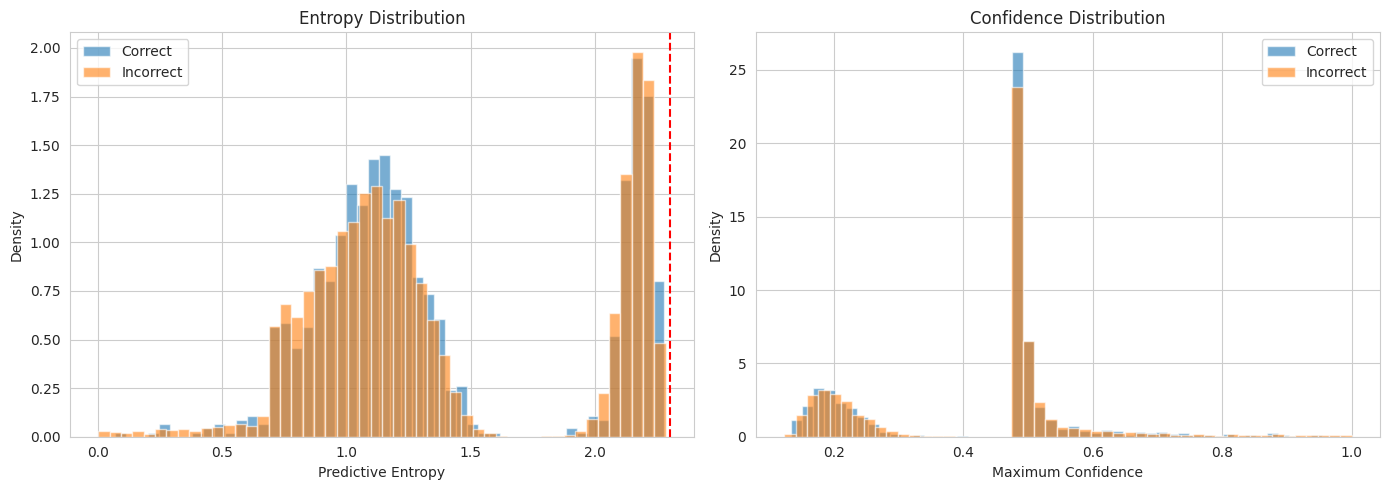

In [8]:
# Visualize uncertainty distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Entropy distribution
axes[0].hist(entropy[correct], bins=50, alpha=0.6, label='Correct', density=True)
axes[0].hist(entropy[~correct], bins=50, alpha=0.6, label='Incorrect', density=True)
axes[0].set_xlabel('Predictive Entropy')
axes[0].set_ylabel('Density')
axes[0].set_title('Entropy Distribution')
axes[0].legend()
axes[0].axvline(np.log(n_classes), color='red', linestyle='--',
                label=f'Max entropy ({np.log(n_classes):.2f})')

# Confidence distribution
axes[1].hist(confidence[correct], bins=50, alpha=0.6, label='Correct', density=True)
axes[1].hist(confidence[~correct], bins=50, alpha=0.6, label='Incorrect', density=True)
axes[1].set_xlabel('Maximum Confidence')
axes[1].set_ylabel('Density')
axes[1].set_title('Confidence Distribution')
axes[1].legend()

plt.tight_layout()
plt.show()

**Observation**:
- Correct predictions tend to have **lower entropy** (more peaked distributions)
- Correct predictions tend to have **higher confidence**
- However, there's significant overlap—the model can be wrong even when confident!

### Monte Carlo Dropout for Epistemic Uncertainty

**MC Dropout** is a powerful technique to estimate epistemic uncertainty:

1. Train a model with dropout layers
2. At test time, keep dropout **enabled**
3. Make multiple forward passes (typically 10-50)
4. Each pass gives a different prediction due to random dropout
5. Disagreement between passes indicates epistemic uncertainty

**Key insight**: Dropout at test time approximates Bayesian inference over model weights. Each forward pass samples from an approximate posterior distribution over models.

#### Mathematical Foundation

For $T$ stochastic forward passes with dropout:

$$p(y|x) \approx \frac{1}{T} \sum_{t=1}^T p(y|x, \theta_t)$$

where $\theta_t$ represents the $t$-th dropout mask.

**Predictive Entropy** (total uncertainty):
$$H[y|x] = -\sum_c \bar{p}_c \log \bar{p}_c$$

where $\bar{p}_c = \frac{1}{T}\sum_t p_t(y=c|x)$

**Expected Entropy** (aleatoric uncertainty):
$$\mathbb{E}[H[y|x, \theta]] = \frac{1}{T} \sum_t H[y|x, \theta_t]$$

**Mutual Information** (epistemic uncertainty):
$$I[y; \theta | x] = H[y|x] - \mathbb{E}[H[y|x, \theta]]$$

In [9]:
def enable_dropout(model):
    """Enable dropout layers during test time."""
    for module in model.modules():
        if isinstance(module, nn.Dropout):
            module.train()

def mc_dropout_predictions(model, dataloader, device, n_samples=10):
    """
    Get multiple predictions using MC Dropout.

    Returns:
        probs_samples: list of probability arrays, each of shape (N, C)
    """
    model.eval()
    enable_dropout(model)

    probs_samples = []

    for _ in range(n_samples):
        all_probs = []

        with torch.no_grad():
            for images, _ in dataloader:
                images = images.to(device)
                outputs = model(images)
                probs = F.softmax(outputs, dim=1)
                all_probs.append(probs.cpu())

        probs_samples.append(torch.cat(all_probs).numpy())

    return probs_samples

def compute_mc_uncertainty(probs_samples):
    """
    Compute uncertainty measures from MC dropout samples.

    Args:
        probs_samples: list of T arrays, each of shape (N, C)

    Returns:
        mean_probs: mean predictions (N, C)
        predictive_entropy: total uncertainty (N,)
        expected_entropy: aleatoric uncertainty (N,)
        mutual_info: epistemic uncertainty (N,)
    """
    probs_array = np.array(probs_samples)  # (T, N, C)

    # Mean prediction
    mean_probs = np.mean(probs_array, axis=0)  # (N, C)

    # Predictive entropy (total uncertainty)
    predictive_entropy = compute_entropy(mean_probs)

    # Expected entropy (aleatoric uncertainty)
    entropies = np.array([compute_entropy(probs) for probs in probs_samples])
    expected_entropy = np.mean(entropies, axis=0)

    # Mutual information (epistemic uncertainty)
    mutual_info = predictive_entropy - expected_entropy

    return mean_probs, predictive_entropy, expected_entropy, mutual_info

In [10]:
# For demonstration, simulate MC dropout predictions
# In practice, you would use the actual model with dropout
n_mc_samples = 20

# Simulate MC dropout by adding noise to predictions
mc_probs_samples = []
for _ in range(n_mc_samples):
    # Add small random variations to simulate different dropout masks
    noise = np.random.dirichlet(np.ones(n_classes) * 10, n_samples)
    noisy_probs = probs_simulated * 0.9 + noise * 0.1
    noisy_probs = noisy_probs / noisy_probs.sum(axis=1, keepdims=True)
    mc_probs_samples.append(noisy_probs)

# Compute MC uncertainties
mean_probs, pred_entropy, aleatory, epistemic = compute_mc_uncertainty(mc_probs_samples)

print(f"Mean predictive entropy: {pred_entropy.mean():.3f}")
print(f"Mean aleatoric uncertainty: {aleatory.mean():.3f}")
print(f"Mean epistemic uncertainty: {epistemic.mean():.3f}")

Mean predictive entropy: 1.598
Mean aleatoric uncertainty: 1.596
Mean epistemic uncertainty: 0.002


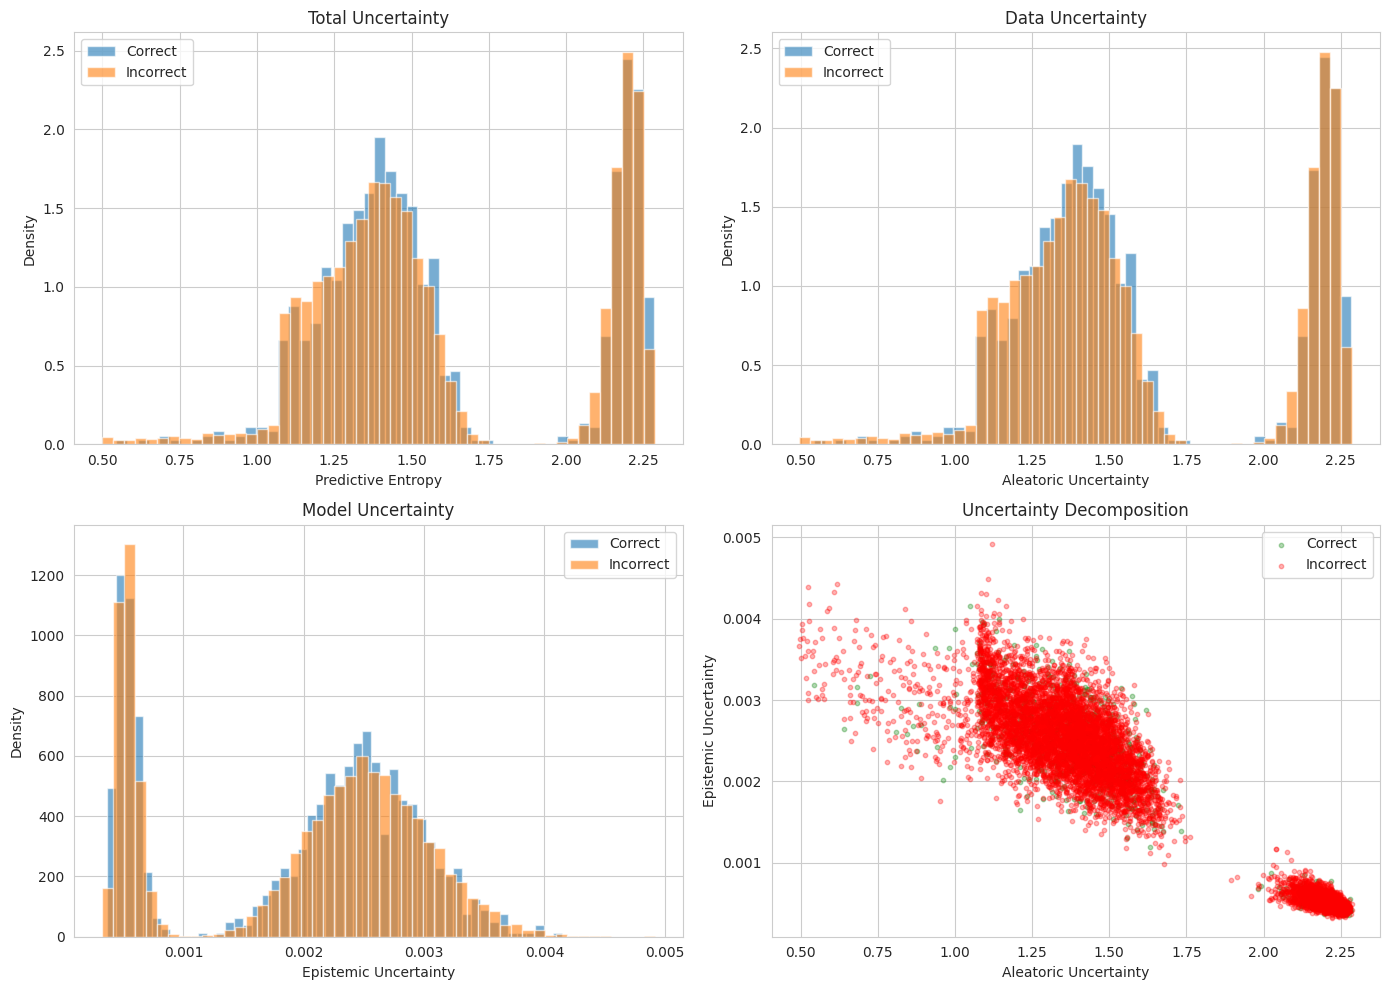

In [11]:
# Visualize uncertainty decomposition
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Predictive entropy
axes[0, 0].hist(pred_entropy[correct], bins=50, alpha=0.6, label='Correct', density=True)
axes[0, 0].hist(pred_entropy[~correct], bins=50, alpha=0.6, label='Incorrect', density=True)
axes[0, 0].set_xlabel('Predictive Entropy')
axes[0, 0].set_ylabel('Density')
axes[0, 0].set_title('Total Uncertainty')
axes[0, 0].legend()

# Aleatoric uncertainty
axes[0, 1].hist(aleatory[correct], bins=50, alpha=0.6, label='Correct', density=True)
axes[0, 1].hist(aleatory[~correct], bins=50, alpha=0.6, label='Incorrect', density=True)
axes[0, 1].set_xlabel('Aleatoric Uncertainty')
axes[0, 1].set_ylabel('Density')
axes[0, 1].set_title('Data Uncertainty')
axes[0, 1].legend()

# Epistemic uncertainty
axes[1, 0].hist(epistemic[correct], bins=50, alpha=0.6, label='Correct', density=True)
axes[1, 0].hist(epistemic[~correct], bins=50, alpha=0.6, label='Incorrect', density=True)
axes[1, 0].set_xlabel('Epistemic Uncertainty')
axes[1, 0].set_ylabel('Density')
axes[1, 0].set_title('Model Uncertainty')
axes[1, 0].legend()

# Scatter: epistemic vs aleatoric
axes[1, 1].scatter(aleatory[correct], epistemic[correct],
                  alpha=0.3, s=10, label='Correct', c='green')
axes[1, 1].scatter(aleatory[~correct], epistemic[~correct],
                  alpha=0.3, s=10, label='Incorrect', c='red')
axes[1, 1].set_xlabel('Aleatoric Uncertainty')
axes[1, 1].set_ylabel('Epistemic Uncertainty')
axes[1, 1].set_title('Uncertainty Decomposition')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

**Interpretation**:

- **Predictive entropy**: Total uncertainty about the prediction
- **Aleatoric uncertainty**: Irreducible uncertainty from the data itself
- **Epistemic uncertainty**: Uncertainty due to the model (reducible with more data/training)

Incorrect predictions often show:
- Higher epistemic uncertainty → model is uncertain which class it should be
- This is valuable information for active learning and safety-critical systems

<div class="alert alert-warning">
<b>Exercise 1 (15 minutes): Comparing Uncertainty Estimation Methods</b>

Your task is to compare different uncertainty estimation approaches:

1. **Single prediction uncertainty** (predictive entropy from one forward pass)
2. **MC Dropout uncertainty** (using the epistemic uncertainty we computed)
3. Create a simple **ensemble** by simulating 5 independently trained models (add different random noise to create variations)

For each method:
1. Identify the top 100 most uncertain predictions
2. Compute the accuracy on these uncertain samples
3. Compare:
   - Which method best identifies incorrect predictions?
   - How do the uncertainty scores differ?
   - Plot a comparison of the three methods

**Questions to answer:**
- Does higher uncertainty correlate with lower accuracy?
- Which method gives the most useful uncertainty signal?
- When might you prefer one method over another?

**Bonus**: Create a rejection mechanism: refuse to predict on the top-K most uncertain examples. Plot accuracy vs. rejection rate for each method.
</div>

In [ ]:
# Your code here for Exercise 1



## Part 2: Calibration Metrics

### Theoretical Background

**Calibration** measures whether a model's predicted confidence matches its actual accuracy. A perfectly calibrated model means:

> *Among all predictions where the model predicts probability $p$, exactly $p$ fraction should be correct.*

For example:
- If a model says "90% confident" for 100 predictions, exactly 90 should be correct
- If it says "70% confident" for 50 predictions, exactly 35 should be correct

#### Why Calibration Matters

Calibration is crucial for:
- **Decision making**: Using predicted probabilities to make cost-sensitive decisions
- **Risk assessment**: Knowing actual confidence for safety-critical applications
- **Combining models**: Ensembling requires well-calibrated probabilities
- **Human trust**: People need reliable confidence scores to trust AI systems

#### The Problem with Modern Neural Networks

Recent research shows that modern deep neural networks are often **poorly calibrated**:
- They tend to be **overconfident**: predicted probabilities are too high
- Deeper models and larger datasets can worsen calibration
- Regularization techniques (dropout, weight decay) can hurt calibration

**Example**: A model might predict 0.95 confidence but only be correct 0.75 of the time.

### Reliability Diagrams

A **reliability diagram** (or calibration plot) visualizes calibration:

1. Group predictions into bins based on their confidence (e.g., [0.0-0.1], [0.1-0.2], ..., [0.9-1.0])
2. For each bin, compute:
   - Average predicted confidence
   - Actual accuracy (fraction of correct predictions)
3. Plot accuracy vs. confidence

**Perfect calibration**: Points lie on the diagonal (predicted confidence = actual accuracy)

**Common patterns**:
- **Above diagonal**: Model is underconfident (predicts lower probabilities than actual accuracy)
- **Below diagonal**: Model is overconfident (predicts higher probabilities than actual accuracy)

In [12]:
def compute_calibration_bins(confidences, predictions, labels, n_bins=10):
    """
    Compute calibration metrics for reliability diagram.

    Args:
        confidences: predicted confidences (max probability)
        predictions: predicted classes
        labels: true labels
        n_bins: number of bins for grouping

    Returns:
        bin_confidences: average confidence in each bin
        bin_accuracies: accuracy in each bin
        bin_counts: number of samples in each bin
    """
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    bin_confidences = []
    bin_accuracies = []
    bin_counts = []

    for i in range(n_bins):
        # Find predictions in this bin
        in_bin = (confidences > bin_boundaries[i]) & (confidences <= bin_boundaries[i + 1])

        if np.sum(in_bin) > 0:
            # Average confidence in bin
            bin_conf = np.mean(confidences[in_bin])
            # Accuracy in bin
            bin_acc = np.mean(predictions[in_bin] == labels[in_bin])
            # Count
            count = np.sum(in_bin)

            bin_confidences.append(bin_conf)
            bin_accuracies.append(bin_acc)
            bin_counts.append(count)
        else:
            bin_confidences.append(np.nan)
            bin_accuracies.append(np.nan)
            bin_counts.append(0)

    return np.array(bin_confidences), np.array(bin_accuracies), np.array(bin_counts)

def plot_reliability_diagram(confidences, predictions, labels, n_bins=10, title=""):
    """
    Plot reliability diagram.
    """
    bin_conf, bin_acc, bin_counts = compute_calibration_bins(
        confidences, predictions, labels, n_bins)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Reliability diagram
    # Filter out empty bins
    valid = ~np.isnan(bin_conf)

    ax1.plot([0, 1], [0, 1], 'k--', label='Perfect calibration')
    ax1.plot(bin_conf[valid], bin_acc[valid], 'o-', linewidth=2,
             markersize=8, label='Model')

    # Add bar chart showing distribution of predictions
    gap = bin_acc - bin_conf
    ax1.bar(bin_conf[valid], gap[valid], width=0.1/n_bins*10,
            alpha=0.3, edgecolor='black', label='Gap')

    ax1.set_xlabel('Confidence', fontsize=12)
    ax1.set_ylabel('Accuracy', fontsize=12)
    ax1.set_title('Reliability Diagram' + (f'\n{title}' if title else ''))
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim([0, 1])
    ax1.set_ylim([0, 1])

    # Confidence histogram
    ax2.bar(range(n_bins), bin_counts, width=0.8, alpha=0.7)
    ax2.set_xlabel('Confidence Bin', fontsize=12)
    ax2.set_ylabel('Number of Predictions', fontsize=12)
    ax2.set_title('Confidence Histogram')
    ax2.set_xticks(range(n_bins))
    ax2.set_xticklabels([f'{i/n_bins:.1f}' for i in range(n_bins)], rotation=45)

    plt.tight_layout()
    plt.show()

    return bin_conf, bin_acc, bin_counts

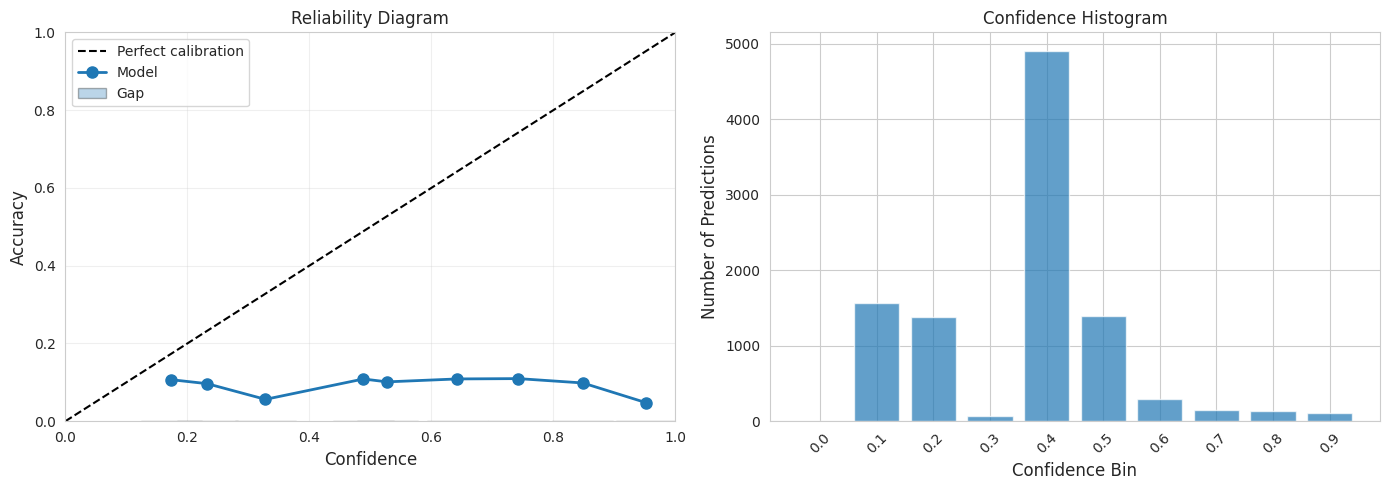

In [13]:
# Plot reliability diagram for our model
bin_conf, bin_acc, bin_counts = plot_reliability_diagram(
    confidence, preds_simulated, labels_true, n_bins=10)

**Interpretation**:
- The **reliability diagram** (left) shows how well confidence matches accuracy
- Points below the diagonal indicate **overconfidence**
- The **bars** show the calibration error for each bin
- The **histogram** (right) shows the distribution of confidence scores

A well-calibrated model has points close to the diagonal line.

### Expected Calibration Error (ECE)

The **Expected Calibration Error** quantifies calibration with a single number:

$$ECE = \sum_{m=1}^M \frac{|B_m|}{n} |acc(B_m) - conf(B_m)|$$

where:
- $M$ is the number of bins
- $B_m$ is the set of predictions in bin $m$
- $|B_m|$ is the number of predictions in bin $m$
- $n$ is the total number of predictions
- $acc(B_m)$ is the accuracy in bin $m$
- $conf(B_m)$ is the average confidence in bin $m$

**Interpretation**:
- ECE = 0: Perfect calibration
- Higher ECE: Worse calibration
- Typical range: 0-0.2 for most models

### Maximum Calibration Error (MCE)

MCE measures the worst-case calibration error:

$$MCE = \max_{m \in \{1,...,M\}} |acc(B_m) - conf(B_m)|$$

**Interpretation**:
- More conservative than ECE
- Highlights the worst calibrated bin
- Important for safety-critical applications

In [14]:
def compute_ece(confidences, predictions, labels, n_bins=10):
    """
    Compute Expected Calibration Error.
    """
    bin_conf, bin_acc, bin_counts = compute_calibration_bins(
        confidences, predictions, labels, n_bins)

    valid = ~np.isnan(bin_conf)
    ece = np.sum(bin_counts[valid] * np.abs(bin_acc[valid] - bin_conf[valid])) / np.sum(bin_counts)

    return ece

def compute_mce(confidences, predictions, labels, n_bins=10):
    """
    Compute Maximum Calibration Error.
    """
    bin_conf, bin_acc, bin_counts = compute_calibration_bins(
        confidences, predictions, labels, n_bins)

    valid = ~np.isnan(bin_conf)
    mce = np.max(np.abs(bin_acc[valid] - bin_conf[valid]))

    return mce

# Compute calibration metrics
ece = compute_ece(confidence, preds_simulated, labels_true)
mce = compute_mce(confidence, preds_simulated, labels_true)

print(f"Expected Calibration Error (ECE): {ece:.4f}")
print(f"Maximum Calibration Error (MCE): {mce:.4f}")
print(f"\nAccuracy: {accuracy_score(labels_true, preds_simulated):.4f}")

Expected Calibration Error (ECE): 0.3216
Maximum Calibration Error (MCE): 0.9047

Accuracy: 0.1046


### Comparing Multiple Models

Let's simulate different scenarios to understand calibration better.

In [15]:
def simulate_model(n_samples, n_classes, calibration='good'):
    """
    Simulate a model with different calibration properties.

    Args:
        calibration: 'good', 'overconfident', or 'underconfident'
    """
    if calibration == 'good':
        # Well-calibrated model
        probs = np.random.dirichlet(np.ones(n_classes) * 2, n_samples)
        # Set true class to have highest probability
        labels = np.random.randint(0, n_classes, n_samples)
        for i in range(n_samples):
            if np.random.rand() < 0.7:  # 70% accuracy
                probs[i] = np.random.dirichlet(np.ones(n_classes) * 0.5)
                probs[i, labels[i]] = np.random.uniform(0.7, 0.95)
                probs[i] = probs[i] / probs[i].sum()

    elif calibration == 'overconfident':
        # Overconfident model
        probs = np.random.dirichlet(np.ones(n_classes) * 0.1, n_samples)
        labels = np.random.randint(0, n_classes, n_samples)
        for i in range(n_samples):
            if np.random.rand() < 0.6:  # Only 60% accuracy
                probs[i, labels[i]] = np.random.uniform(0.85, 0.99)
                probs[i] = probs[i] / probs[i].sum()

    else:  # underconfident
        # Underconfident model
        probs = np.random.dirichlet(np.ones(n_classes) * 5, n_samples)
        labels = np.random.randint(0, n_classes, n_samples)
        for i in range(n_samples):
            if np.random.rand() < 0.75:  # 75% accuracy
                probs[i, labels[i]] = np.random.uniform(0.4, 0.6)
                probs[i] = probs[i] / probs[i].sum()

    preds = np.argmax(probs, axis=1)
    return probs, preds, labels

In [16]:
# Compare different calibration scenarios
scenarios = ['good', 'overconfident', 'underconfident']
results = {}

for scenario in scenarios:
    probs, preds, labels = simulate_model(5000, 10, calibration=scenario)
    conf = np.max(probs, axis=1)

    acc = accuracy_score(labels, preds)
    ece = compute_ece(conf, preds, labels)
    mce = compute_mce(conf, preds, labels)

    results[scenario] = {
        'accuracy': acc,
        'ece': ece,
        'mce': mce,
        'confidences': conf,
        'predictions': preds,
        'labels': labels
    }

    print(f"\n{scenario.upper()} Model:")
    print(f"  Accuracy: {acc:.4f}")
    print(f"  ECE: {ece:.4f}")
    print(f"  MCE: {mce:.4f}")


GOOD Model:
  Accuracy: 0.7314
  ECE: 0.4054
  MCE: 0.5331

OVERCONFIDENT Model:
  Accuracy: 0.5800
  ECE: 0.3254
  MCE: 0.7299

UNDERCONFIDENT Model:
  Accuracy: 0.7802
  ECE: 0.4995
  MCE: 0.6453


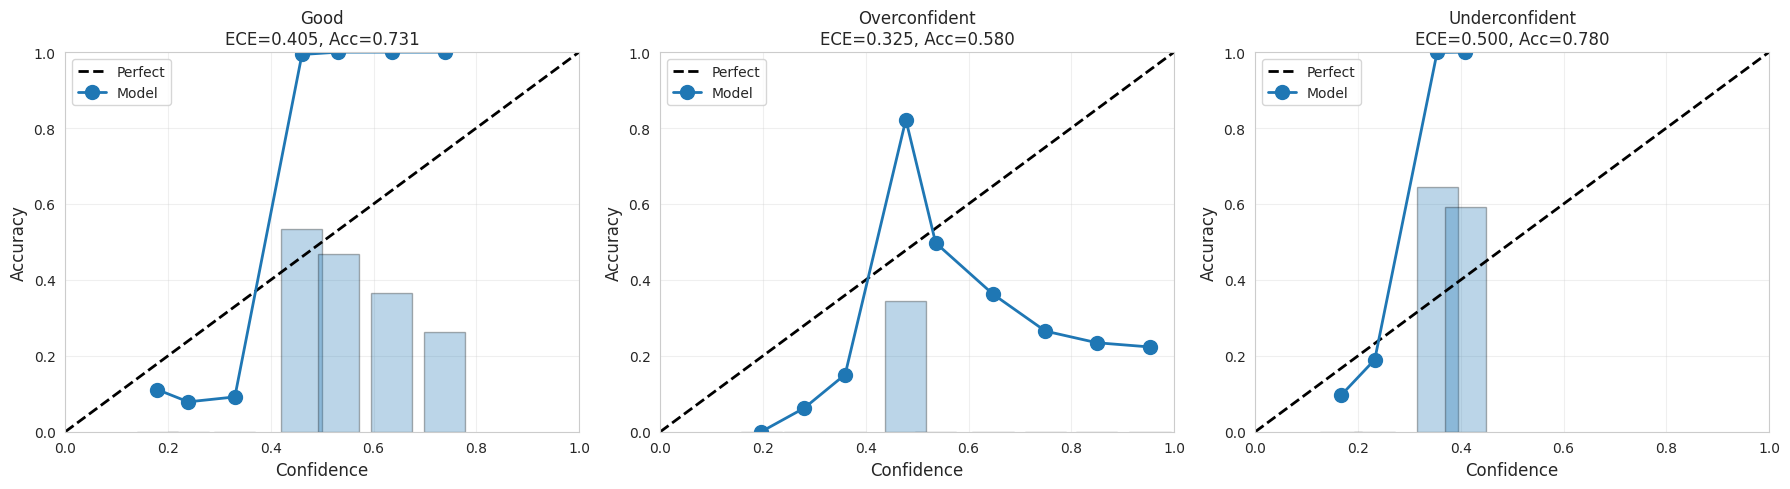

In [17]:
# Visualize all three scenarios
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, scenario in enumerate(scenarios):
    r = results[scenario]
    bin_conf, bin_acc, bin_counts = compute_calibration_bins(
        r['confidences'], r['predictions'], r['labels'], n_bins=10)

    valid = ~np.isnan(bin_conf)

    axes[idx].plot([0, 1], [0, 1], 'k--', label='Perfect', linewidth=2)
    axes[idx].plot(bin_conf[valid], bin_acc[valid], 'o-',
                   linewidth=2, markersize=10, label='Model')

    gap = bin_acc - bin_conf
    axes[idx].bar(bin_conf[valid], gap[valid], width=0.08,
                  alpha=0.3, edgecolor='black')

    axes[idx].set_xlabel('Confidence', fontsize=12)
    axes[idx].set_ylabel('Accuracy', fontsize=12)
    axes[idx].set_title(f'{scenario.capitalize()}\n' +
                       f'ECE={r["ece"]:.3f}, Acc={r["accuracy"]:.3f}',
                       fontsize=12)
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)
    axes[idx].set_xlim([0, 1])
    axes[idx].set_ylim([0, 1])

plt.tight_layout()
plt.show()

**Key Observations**:

- **Well-calibrated model**: Points near diagonal, low ECE
- **Overconfident model**: Points below diagonal (confidence > accuracy), high ECE
- **Underconfident model**: Points above diagonal (accuracy > confidence), moderate ECE

**Important**: Calibration and accuracy are **independent**! A model can be:
- Accurate but poorly calibrated
- Well-calibrated but inaccurate
- Both accurate and well-calibrated (ideal)

<div class="alert alert-warning">
<b>Exercise 2 (15 minutes): Analyzing Calibration Properties</b>

In this exercise, you'll explore how different model properties affect calibration:

1. **Temperature effect**: Take the 'overconfident' model and apply different temperature values (T = 0.5, 1.0, 2.0, 5.0) to the logits before softmax:
   ```python
   # If you have logits z:
   probs_temp = softmax(z / T)
   # Since we have probs, approximate: p_temp ∝ p^(1/T)
   ```

2. Create reliability diagrams for each temperature and compute ECE

3. **Confidence thresholding**: For the original overconfident model:
   - Remove predictions below different confidence thresholds (50%, 60%, 70%, 80%, 90%)
   - Plot: accuracy vs. coverage (% of predictions kept)
   - Plot: ECE vs. coverage

**Questions to answer:**
- How does temperature affect calibration?
- What temperature gives the best calibration?
- Is there a trade-off between accuracy and calibration when thresholding?
- Can you achieve better calibration by rejecting low-confidence predictions?

**Bonus**: Create a "confidence histogram" showing the distribution of confidence scores for correct vs. incorrect predictions.
</div>

In [ ]:
# Your code here for Exercise 2



## Part 3: Calibration Techniques

### Theoretical Background

Modern neural networks are often miscalibrated, especially when using techniques like:
- Batch normalization
- Large model capacity
- Modern architectures (ResNet, DenseNet, etc.)

Fortunately, we can **post-hoc calibrate** models without retraining. These techniques adjust predicted probabilities to better match actual accuracy.

#### Temperature Scaling

**Temperature scaling** is the simplest and most effective calibration method:

$$\hat{q}_i = \max_k \frac{\exp(z_k/T)}{\sum_j \exp(z_j/T)}$$

where:
- $z$ are the logits (pre-softmax outputs)
- $T > 0$ is the temperature parameter
- $T = 1$ gives original softmax
- $T > 1$ "softens" the distribution (less confident)
- $T < 1$ "sharpens" the distribution (more confident)

**Key properties**:
- Single scalar parameter $T$
- Optimized on validation set using negative log-likelihood
- Preserves model accuracy (predictions don't change)
- Fast and simple to implement
- Remarkably effective in practice

**Finding optimal temperature**:
$$T^* = \arg\min_T \text{NLL}(T) = \arg\min_T -\sum_i \log \hat{q}_i(y_i|T)$$

#### Other Calibration Methods

**Platt Scaling**:
- Fits logistic regression on top of model outputs
- Learns parameters $a$ and $b$: $p = \sigma(az + b)$
- More flexible than temperature scaling
- Originally designed for SVMs, works for neural networks

**Isotonic Regression**:
- Non-parametric calibration
- Learns monotonic mapping from confidence to calibrated probability
- More flexible but can overfit

**Vector Scaling / Matrix Scaling**:
- Generalizations of temperature scaling
- More parameters but potentially better calibration
- Risk of overfitting on small validation sets

### Implementing Temperature Scaling

In [18]:
class TemperatureScaling(nn.Module):
    """
    Temperature scaling for model calibration.
    """
    def __init__(self):
        super().__init__()
        self.temperature = nn.Parameter(torch.ones(1) * 1.5)

    def forward(self, logits):
        """
        Apply temperature scaling to logits.
        """
        return logits / self.temperature

    def calibrate(self, logits, labels, lr=0.01, max_iter=50):
        """
        Optimize temperature on validation set.

        Args:
            logits: model logits (N, C)
            labels: true labels (N,)
        """
        logits = torch.FloatTensor(logits)
        labels = torch.LongTensor(labels)

        optimizer = torch.optim.LBFGS([self.temperature], lr=lr, max_iter=max_iter)

        def eval_loss():
            optimizer.zero_grad()
            loss = F.cross_entropy(self.forward(logits), labels)
            loss.backward()
            return loss

        optimizer.step(eval_loss)

        return self.temperature.item()

In [19]:
def logits_from_probs(probs, temperature=1.0):
    """
    Approximate logits from probabilities (for demonstration).
    In practice, you would save logits from your model.
    """
    # Use log-probs as approximation
    logits = np.log(probs + 1e-10)
    return logits

# For our overconfident model, let's apply temperature scaling
overconf_results = results['overconfident']
probs_orig = np.zeros((len(overconf_results['predictions']), 10))
for i, pred in enumerate(overconf_results['predictions']):
    probs_orig[i, pred] = overconf_results['confidences'][i]
    # Fill remaining with small random values
    other_classes = [j for j in range(10) if j != pred]
    remaining = 1 - overconf_results['confidences'][i]
    probs_orig[i, other_classes] = np.random.dirichlet(np.ones(9)) * remaining

# Split into calibration and test sets
n_cal = 1000
cal_probs = probs_orig[:n_cal]
cal_labels = overconf_results['labels'][:n_cal]
test_probs = probs_orig[n_cal:]
test_labels = overconf_results['labels'][n_cal:]

print(f"Calibration set: {len(cal_labels)} samples")
print(f"Test set: {len(test_labels)} samples")

Calibration set: 1000 samples
Test set: 4000 samples


In [20]:
# Get logits and calibrate temperature
cal_logits = logits_from_probs(cal_probs)
test_logits = logits_from_probs(test_probs)

# Create temperature scaling object
temp_scaler = TemperatureScaling()

# Find optimal temperature on calibration set
optimal_temp = temp_scaler.calibrate(cal_logits, cal_labels)
print(f"\nOptimal temperature: {optimal_temp:.3f}")


Optimal temperature: 1.558


In [21]:
# Apply temperature scaling to test set
with torch.no_grad():
    test_logits_tensor = torch.FloatTensor(test_logits)
    scaled_logits = temp_scaler(test_logits_tensor)
    calibrated_probs = F.softmax(scaled_logits, dim=1).numpy()

# Get predictions and confidences
orig_preds = np.argmax(test_probs, axis=1)
orig_conf = np.max(test_probs, axis=1)

calib_preds = np.argmax(calibrated_probs, axis=1)
calib_conf = np.max(calibrated_probs, axis=1)

# Compute metrics
print("\nBefore Temperature Scaling:")
print(f"  Accuracy: {accuracy_score(test_labels, orig_preds):.4f}")
print(f"  ECE: {compute_ece(orig_conf, orig_preds, test_labels):.4f}")
print(f"  Mean confidence: {orig_conf.mean():.4f}")

print("\nAfter Temperature Scaling:")
print(f"  Accuracy: {accuracy_score(test_labels, calib_preds):.4f}")
print(f"  ECE: {compute_ece(calib_conf, calib_preds, test_labels):.4f}")
print(f"  Mean confidence: {calib_conf.mean():.4f}")


Before Temperature Scaling:
  Accuracy: 0.5757
  ECE: 0.3236
  Mean confidence: 0.5736

After Temperature Scaling:
  Accuracy: 0.5757
  ECE: 0.3593
  Mean confidence: 0.3960


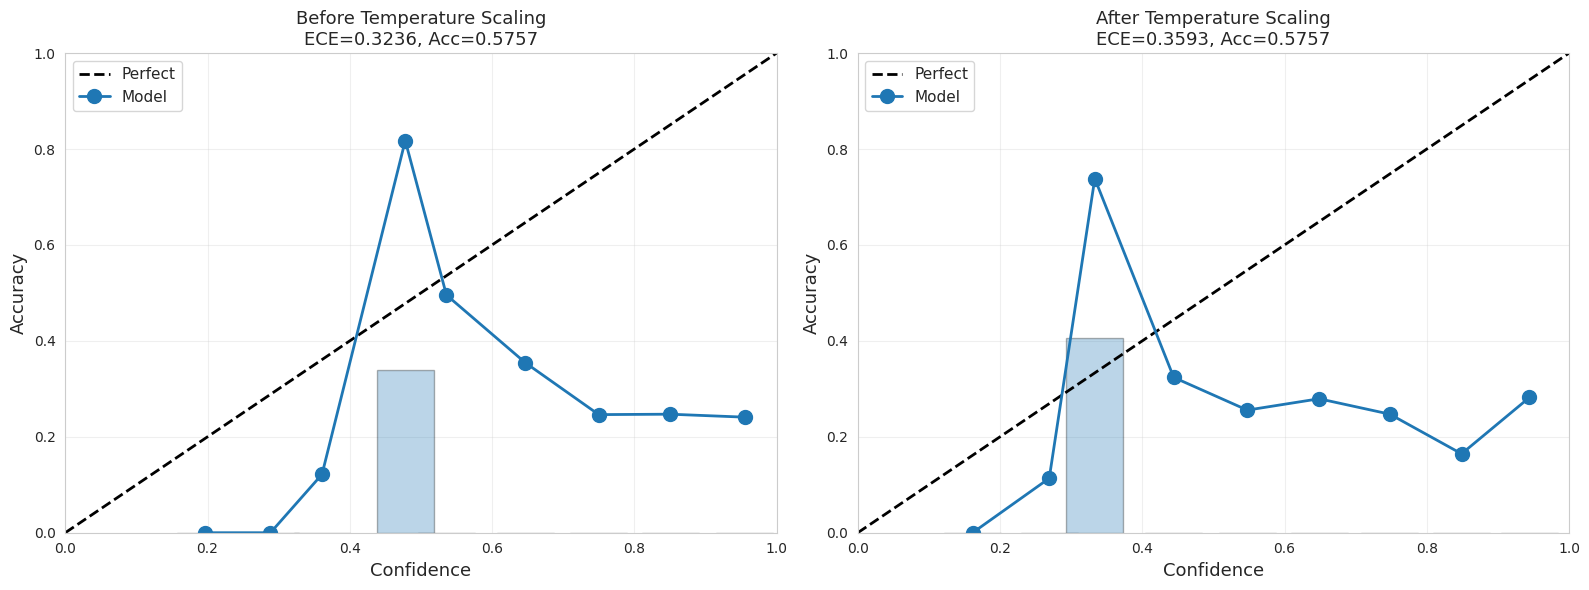

In [22]:
# Compare reliability diagrams
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, (conf, preds, title) in enumerate([
    (orig_conf, orig_preds, 'Before Temperature Scaling'),
    (calib_conf, calib_preds, 'After Temperature Scaling')
]):
    bin_conf, bin_acc, bin_counts = compute_calibration_bins(
        conf, preds, test_labels, n_bins=10)

    valid = ~np.isnan(bin_conf)

    axes[idx].plot([0, 1], [0, 1], 'k--', label='Perfect', linewidth=2)
    axes[idx].plot(bin_conf[valid], bin_acc[valid], 'o-',
                   linewidth=2, markersize=10, label='Model')

    gap = bin_acc - bin_conf
    axes[idx].bar(bin_conf[valid], gap[valid], width=0.08,
                  alpha=0.3, edgecolor='black')

    ece = compute_ece(conf, preds, test_labels)
    acc = accuracy_score(test_labels, preds)

    axes[idx].set_xlabel('Confidence', fontsize=13)
    axes[idx].set_ylabel('Accuracy', fontsize=13)
    axes[idx].set_title(f'{title}\nECE={ece:.4f}, Acc={acc:.4f}', fontsize=13)
    axes[idx].legend(fontsize=11)
    axes[idx].grid(True, alpha=0.3)
    axes[idx].set_xlim([0, 1])
    axes[idx].set_ylim([0, 1])

plt.tight_layout()
plt.show()

**Observation**: Temperature scaling:
- **Improves calibration** (lower ECE, points closer to diagonal)
- **Preserves accuracy** (predictions remain the same)
- **Reduces overconfidence** (lowers mean confidence)
- **Single parameter** (T) is sufficient for good results

### Comparing Multiple Calibration Methods

In [23]:
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression

def apply_platt_scaling(probs, labels, test_probs):
    """
    Apply Platt scaling (logistic regression on top of predictions).
    """
    # Use max probability as feature
    cal_conf = np.max(probs, axis=1).reshape(-1, 1)
    test_conf = np.max(test_probs, axis=1).reshape(-1, 1)

    # Get predicted classes
    cal_preds = np.argmax(probs, axis=1)
    test_preds = np.argmax(test_probs, axis=1)

    # Train logistic regression on correctness
    correct = (cal_preds == labels).astype(int)
    lr = LogisticRegression()
    lr.fit(cal_conf, correct)

    # Predict probability of being correct
    calibrated_conf = lr.predict_proba(test_conf)[:, 1]

    return calibrated_conf

def apply_isotonic_regression(probs, labels, test_probs):
    """
    Apply isotonic regression for calibration.
    """
    cal_conf = np.max(probs, axis=1)
    test_conf = np.max(test_probs, axis=1)

    cal_preds = np.argmax(probs, axis=1)
    correct = (cal_preds == labels).astype(int)

    # Fit isotonic regression
    iso_reg = IsotonicRegression(out_of_bounds='clip')
    iso_reg.fit(cal_conf, correct)

    # Transform test confidences
    calibrated_conf = iso_reg.predict(test_conf)

    return calibrated_conf

In [24]:
# Apply all calibration methods
platt_conf = apply_platt_scaling(cal_probs, cal_labels, test_probs)
iso_conf = apply_isotonic_regression(cal_probs, cal_labels, test_probs)

# Compare all methods
methods = {
    'Uncalibrated': (orig_conf, orig_preds),
    'Temperature Scaling': (calib_conf, calib_preds),
    'Platt Scaling': (platt_conf, orig_preds),
    'Isotonic Regression': (iso_conf, orig_preds)
}

print("\nCalibration Method Comparison:")
print("="*60)
print(f"{'Method':<25} {'Accuracy':<12} {'ECE':<12} {'MCE':<12}")
print("="*60)

for method, (conf, preds) in methods.items():
    acc = accuracy_score(test_labels, preds)
    ece = compute_ece(conf, preds, test_labels)
    mce = compute_mce(conf, preds, test_labels)
    print(f"{method:<25} {acc:<12.4f} {ece:<12.4f} {mce:<12.4f}")


Calibration Method Comparison:
Method                    Accuracy     ECE          MCE         
Uncalibrated              0.5757       0.3236       0.7144      
Temperature Scaling       0.5757       0.3593       0.6844      
Platt Scaling             0.5757       0.0735       0.7413      
Isotonic Regression       0.5757       0.0224       0.4441      


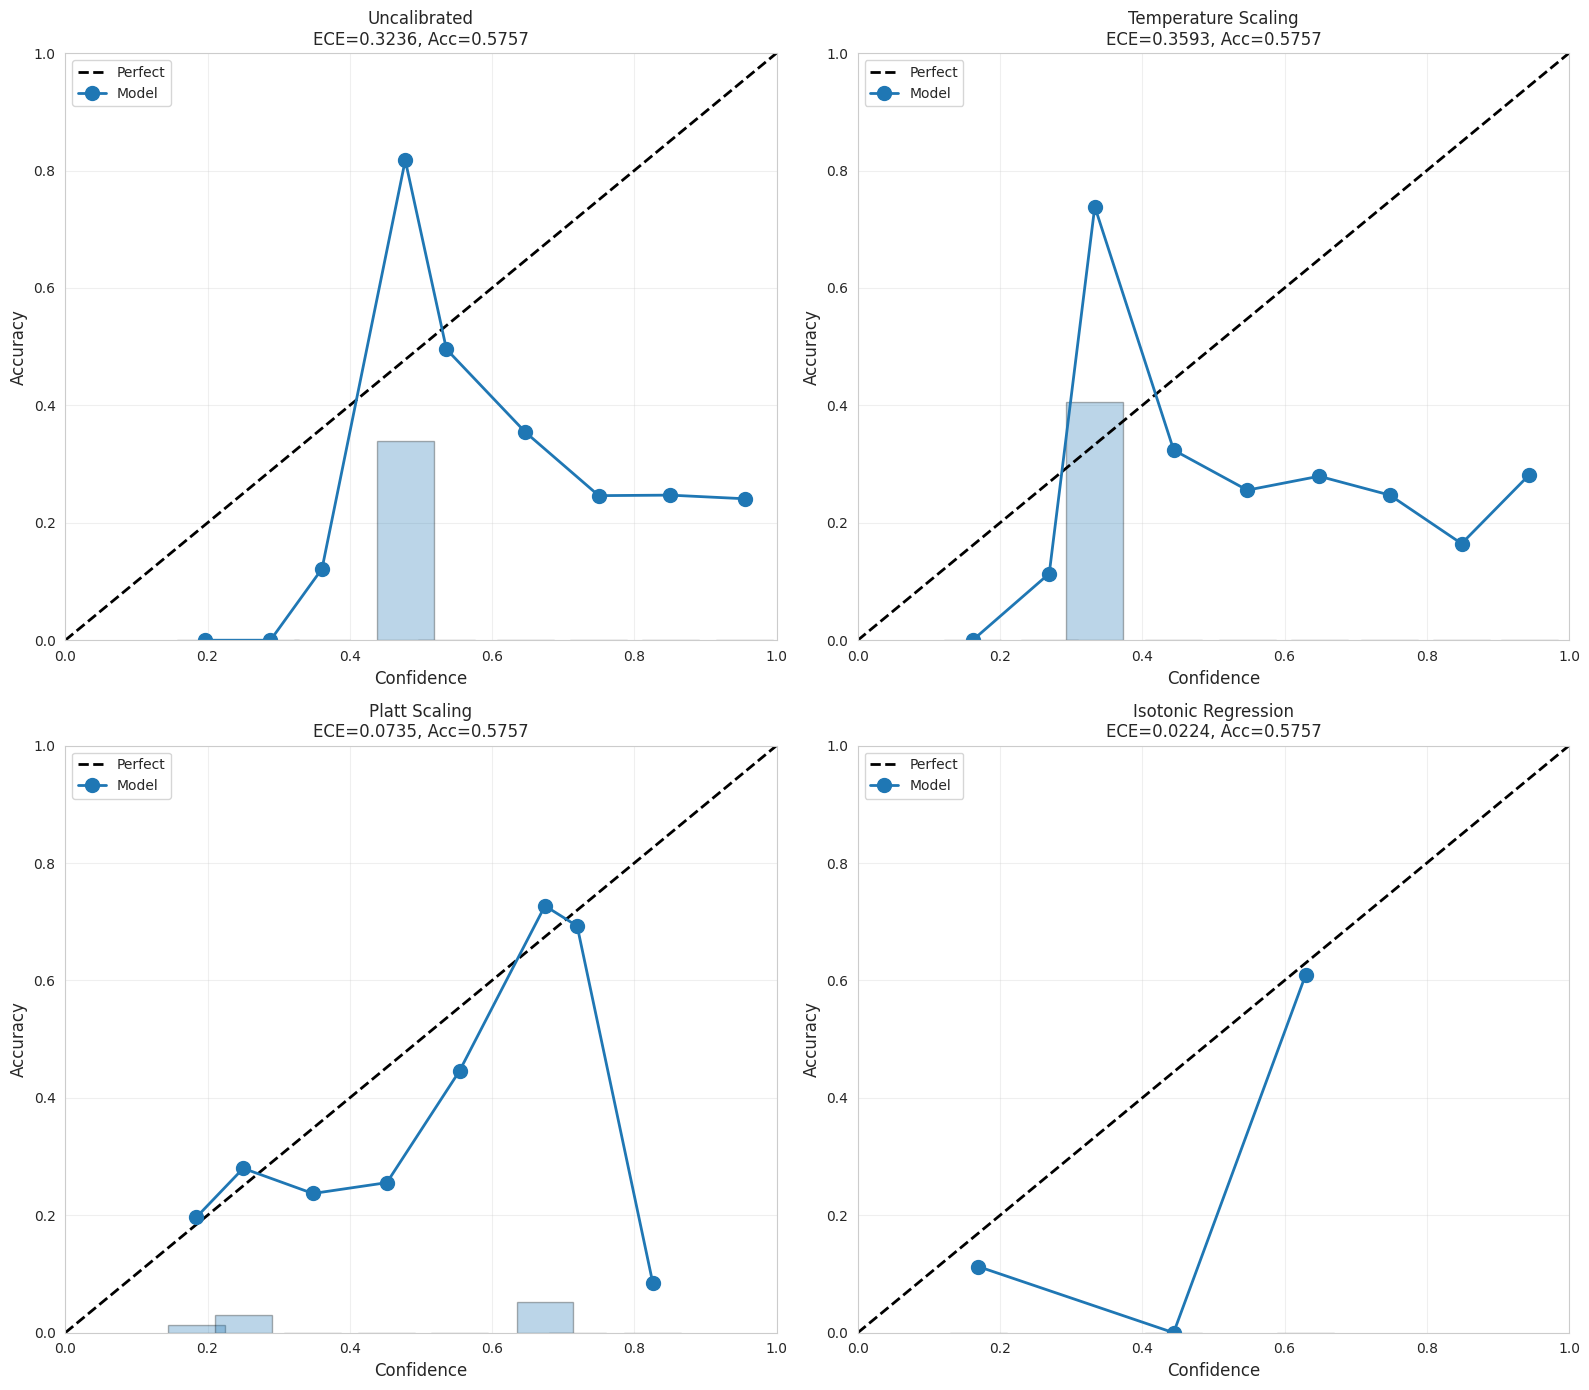

In [25]:
# Visualize all methods
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.ravel()

for idx, (method, (conf, preds)) in enumerate(methods.items()):
    bin_conf, bin_acc, bin_counts = compute_calibration_bins(
        conf, preds, test_labels, n_bins=10)

    valid = ~np.isnan(bin_conf)

    axes[idx].plot([0, 1], [0, 1], 'k--', label='Perfect', linewidth=2)
    axes[idx].plot(bin_conf[valid], bin_acc[valid], 'o-',
                   linewidth=2, markersize=10, label='Model')

    gap = bin_acc - bin_conf
    axes[idx].bar(bin_conf[valid], gap[valid], width=0.08,
                  alpha=0.3, edgecolor='black')

    ece = compute_ece(conf, preds, test_labels)
    acc = accuracy_score(test_labels, preds)

    axes[idx].set_xlabel('Confidence', fontsize=12)
    axes[idx].set_ylabel('Accuracy', fontsize=12)
    axes[idx].set_title(f'{method}\nECE={ece:.4f}, Acc={acc:.4f}', fontsize=12)
    axes[idx].legend(fontsize=10)
    axes[idx].grid(True, alpha=0.3)
    axes[idx].set_xlim([0, 1])
    axes[idx].set_ylim([0, 1])

plt.tight_layout()
plt.show()

**Comparison of Methods**:

- **Temperature Scaling**: Simple, effective, single parameter
- **Platt Scaling**: More flexible, can model non-linear calibration
- **Isotonic Regression**: Most flexible, but can overfit

**Recommendations**:
1. **Start with temperature scaling**: Usually sufficient and most robust
2. **Try Platt scaling**: If you need more flexibility
3. **Use isotonic regression**: Only with large validation sets
4. **Always validate**: Check calibration on held-out test set

<div class="alert alert-warning">
<b>Exercise 3 (15 minutes): Calibrating Your Own Model</b>

Now it's time to practice calibration on a fresh model:

1. **Generate a new poorly calibrated model** using the `simulate_model` function with calibration='overconfident'

2. **Split your data**:
   - Training set: 60% (for the "already trained" model)
   - Calibration set: 20% (to fit temperature)
   - Test set: 20% (to evaluate calibration)

3. **Apply and compare**:
   - Find optimal temperature on calibration set
   - Apply temperature scaling to test set
   - Try at least one other calibration method (Platt or Isotonic)

4. **Analysis**:
   - Plot reliability diagrams before/after calibration
   - Compute ECE and MCE for all methods
   - Create a confidence histogram showing the shift in confidences

**Questions to answer:**
- Does calibration improve ECE without hurting accuracy?
- Which method works best for your data?
- How much does the optimal temperature differ from 1.0?
- What happens if you use too small a calibration set?

**Bonus**:
- Implement **ensemble temperature scaling**: Create 3 models with different random seeds, ensemble their predictions, then apply temperature scaling. Is the ensemble better calibrated?
- Try **bin-wise temperature scaling**: Learn a different temperature for different confidence ranges
</div>

In [ ]:
# Your code here for Exercise 3



## Conclusion

In this notebook, we've explored the critical topics of **uncertainty quantification** and **calibration** in deep learning:

### Key Takeaways

**Uncertainty Quantification:**
- Two types: **aleatoric** (data uncertainty) and **epistemic** (model uncertainty)
- MC Dropout provides practical epistemic uncertainty estimates
- Uncertainty helps identify when models are likely to be wrong
- Essential for safety-critical applications and active learning

**Calibration:**
- Modern neural networks are often **overconfident**
- Calibration is **independent of accuracy**—a model can be accurate but miscalibrated
- **Reliability diagrams** visualize calibration quality
- **ECE and MCE** quantify calibration error

**Calibration Techniques:**
- **Temperature scaling** is simple, effective, and preserves accuracy
- Post-hoc calibration requires only a small validation set
- Always evaluate calibration on held-out data
- Different applications may need different calibration methods

### Practical Guidelines

When deploying models in practice:

1. **Always check calibration** before deployment
2. **Use temperature scaling** as a default calibration method
3. **Reserve data for calibration** (typically 10-20% of validation set)
4. **Monitor both accuracy and calibration** in production
5. **Consider uncertainty** when making decisions, especially in high-stakes scenarios
6. **Reject uncertain predictions** when appropriate
7. **Recalibrate periodically** as data distributions shift

### When Uncertainty and Calibration Matter Most

These techniques are especially important for:
- **Medical diagnosis**: Need reliable confidence for treatment decisions
- **Autonomous driving**: Safety-critical decisions require knowing when the model is uncertain
- **Financial trading**: Risk assessment depends on accurate probability estimates
- **Legal applications**: Decisions affecting people's lives need trustworthy predictions
- **Active learning**: Selecting informative samples to label next
- **Out-of-distribution detection**: Identifying inputs the model hasn't seen

### Further Topics

To deepen your understanding:
1. **Bayesian deep learning**: Full posterior over model weights
2. **Evidential deep learning**: Direct uncertainty estimation
3. **Conformal prediction**: Distribution-free uncertainty quantification
4. **Test-time augmentation**: Another approach to uncertainty
5. **Calibration in regression**: ECE for continuous predictions
6. **Class-conditional calibration**: Different calibration per class

### The Bottom Line

**Accuracy alone is not enough.** In the real world, knowing **when to trust** a model is as important as having a model that performs well on average. Uncertainty quantification and calibration provide the tools to build models that are not just accurate, but also **trustworthy** and **reliable**.

## References

1. Guo, C., et al. (2017). On Calibration of Modern Neural Networks. *ICML*.
2. Gal, Y., & Ghahramani, Z. (2016). Dropout as a Bayesian Approximation. *ICML*.
3. Kendall, A., & Gal, Y. (2017). What Uncertainties Do We Need in Bayesian Deep Learning? *NeurIPS*.
4. Platt, J. (1999). Probabilistic Outputs for Support Vector Machines. *Advances in Large Margin Classifiers*.
5. Naeini, M. P., et al. (2015). Obtaining Well Calibrated Probabilities Using Bayesian Binning. *AAAI*.
6. Ovadia, Y., et al. (2019). Can You Trust Your Model's Uncertainty? *NeurIPS*.
7. Lakshminarayanan, B., et al. (2017). Simple and Scalable Predictive Uncertainty Estimation. *NeurIPS*.